Plotting, using SVG:

In [1]:
using FFTW
using PyCall
using PyPlot
using Statistics

PyPlot.svg(true)

corner = pyimport("corner")

┌ Info: Recompiling stale cache file /Users/wfarr/.julia/compiled/v1.2/FFTW/PvIn2.ji for FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/wfarr/.julia/compiled/v1.2/PyCall/GkzkC.ji for PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/wfarr/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


PyObject <module 'corner' from '/Users/wfarr/anaconda3/lib/python3.7/site-packages/corner/__init__.py'>

We discussed a simple model in class, where we have a circuit with two resistors in series, a battery, and an ammeter.  The ammeter makes a (noisy) measurement of the current $I$ flowing through the circuit; the battery is at voltage $V$; one of the resistors has been calibrated and is adjustable by us; and we want to measure the resistance, $R$ of the other resistor.  Let the setting of the adjustable resistor be $x$, and the measured current $y$; then we have 
$$
y = I + \mathrm{noise} = \frac{V}{R + x} + \mathrm{noise}.
$$

If we model the noise as a Gaussian with zero mean and unknown standard deviation, $\sigma$, then we have three parameters ($V$, $R$, $\sigma$) to measure.  We have 
$$
y = \frac{V}{R + x} + \epsilon
$$
with $\epsilon \sim N(0,\sigma)$.  Under repeated measurements (assuming statistically independent noise on each measurement) with different settings of $x$, we obtain a data set $\left( y_i, x_i \right)$ whose likelihood is 
$$
p\left( \left\{ x_i, y_i \right\} \mid V, R, \sigma \right) = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi} \sigma} \exp\left[ -\frac{1}{2} \left( \frac{\frac{V}{R + x_i} - y_i}{\sigma} \right)^2 \right]
$$

Here we will construct a MCMC sampler for $V,R,\sigma$ given such a data set.  First, to generate mock data, we choose true values of the parameters:

In [2]:
Rtrue = 1000.0
Vtrue = 3.0
sigma_true = 1e-4

0.0001

Now we choose a large number of dial settings, and measure the current in each one (adding noise as we go):

In [44]:
xs = exp.(collect(log(Rtrue/10):0.1:log(10*Rtrue)))
ys = Vtrue./(Rtrue .+ xs) .+ sigma_true.*randn(length(xs));

Here's our data set:

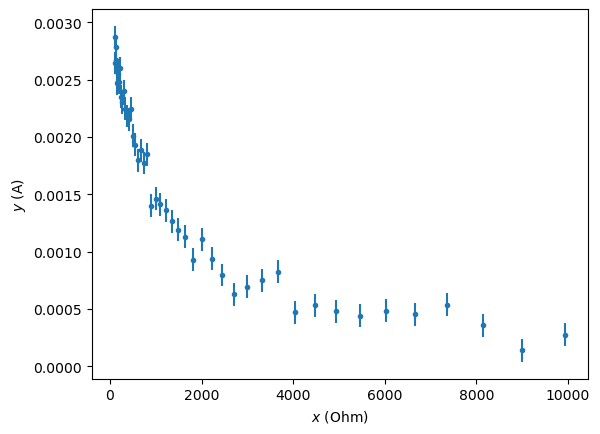

PyObject Text(28.0, 0.5, '$y$ ($\\mathrm{A}$)')

In [45]:
errorbar(xs, ys, yerr=sigma_true, fmt=".")
xlabel(L"$x$ ($\mathrm{Ohm}$)")
ylabel(L"$y$ ($\mathrm{A}$)")

This is the MCMC algorithm.  `theta` is the current state, `proposal` takes `theta`, and returns a proposed update to the state, `theta_new`, `log_proposal_density(x, y)` returns the probability that the proposal would give `x` when we are at position `y`, and `log_prob` gives the log of the probability of a state.

In [5]:
function next_mcmc_state(theta, proposal, log_proposal_density, log_prob)
    theta_prime = proposal(theta)
    log_post_ratio = log_prob(theta_prime) - log_prob(theta)
    log_prop_ratio = log_proposal_density(theta, theta_prime) - log_proposal_density(theta_prime, theta)
    log_paccept = log_post_ratio + log_prop_ratio
    if log(rand()) < log_paccept
        theta_prime
    else
        theta
    end
end

next_mcmc_state (generic function with 1 method)

Let's test our MCMC (and break it!) by trying to reproduce a $N(0,1)$ distribution.  Here is the log-probility, proposal, and proposal density (here $p\left(x \mid y\right) == p\left( y \mid x \right)$, so we just return 0).  We will see what happens when we change the scale of the proposal from one that is well-adapted to our probability distribution (i.e. $\mathcal{O}(1)$) to one that is poorly adapted.

In [17]:
function log_prob_unit_normal(x)
    return -0.5*x*x
end
function make_proposal(scale)
    function proposal(x)
    x + scale*randn()
    end
end
proposal_unit_normal = make_proposal(1.0)
proposal_unit_normal_toosmall = make_proposal(1e-2)
proposal_unit_normal_toobig = make_proposal(100.0)
function log_proposal_density_unit_normal(x, y)
    zero(x)
end

log_proposal_density_unit_normal (generic function with 1 method)

In [18]:
xs = [0.0]
for i in 1:10000
    push!(xs, next_mcmc_state(xs[end], proposal_unit_normal, log_proposal_density_unit_normal, log_prob_unit_normal))
end

Here is a histogram of the samples we generated, which looks pretty unit-normal-y:

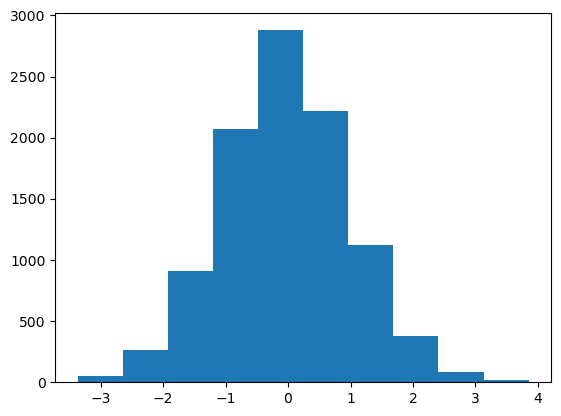

([53.0, 267.0, 914.0, 2075.0, 2879.0, 2216.0, 1119.0, 376.0, 86.0, 16.0], [-3.36586687372586, -2.6441524956164653, -1.92243811750707, -1.2007237393976746, -0.47900936128827976, 0.24270501682111512, 0.9644193949305109, 1.6861337730399057, 2.4078481511493006, 3.1295625292586955, 3.85127690736809], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x13387b240>, PyObject <matplotlib.patches.Rectangle object at 0x13329a208>, PyObject <matplotlib.patches.Rectangle object at 0x13387b7b8>, PyObject <matplotlib.patches.Rectangle object at 0x13387bac8>, PyObject <matplotlib.patches.Rectangle object at 0x13387bdd8>, PyObject <matplotlib.patches.Rectangle object at 0x13387bef0>, PyObject <matplotlib.patches.Rectangle object at 0x133444438>, PyObject <matplotlib.patches.Rectangle object at 0x133444748>, PyObject <matplotlib.patches.Rectangle object at 0x133444a58>, PyObject <matplotlib.patches.Rectangle object at 0x133444d68>])

In [19]:
hist(xs)

Here is the "trace" of the sampling, showing where the state was as a function of iteration.  Because this trace seems to jump around randomly, the sampling is probably pretty good (we will learn later how to quantify "pretty good").

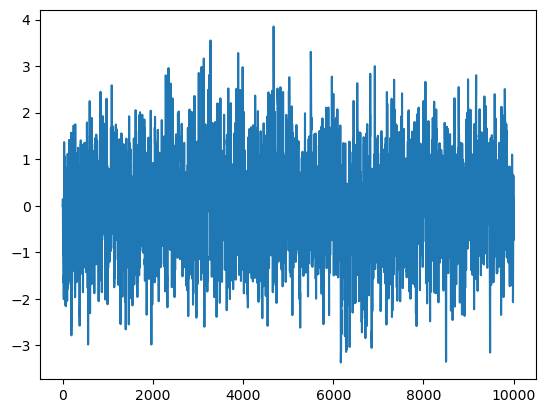

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1336509b0>

In [20]:
plot(xs)

The mean and s.d. are pretty close to the true values:

In [21]:
mean(xs), std(xs)

(-0.03666832581096661, 1.0214066708405387)

Now we will repeat this exercise for the "bad" proposals:

In [22]:
xs = [0.0]
for i in 1:10000
    push!(xs, next_mcmc_state(xs[end], proposal_unit_normal_toosmall, log_proposal_density_unit_normal, log_prob_unit_normal))
end

Here is a histogram of the samples we generated, which no longer looks very good at all!

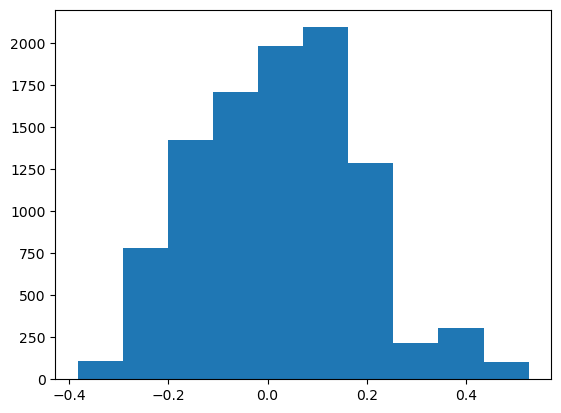

([108.0, 779.0, 1423.0, 1708.0, 1983.0, 2092.0, 1285.0, 213.0, 305.0, 105.0], [-0.3824505336866407, -0.29158692942457987, -0.20072332516251895, -0.10985972090045804, -0.018996116638397176, 0.07186748762366368, 0.16273109188572465, 0.2535946961477855, 0.3444583004098464, 0.43532190467190723, 0.5261855089339682], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x132814dd8>, PyObject <matplotlib.patches.Rectangle object at 0x132814ba8>, PyObject <matplotlib.patches.Rectangle object at 0x132829390>, PyObject <matplotlib.patches.Rectangle object at 0x1328296a0>, PyObject <matplotlib.patches.Rectangle object at 0x1328299b0>, PyObject <matplotlib.patches.Rectangle object at 0x132829cc0>, PyObject <matplotlib.patches.Rectangle object at 0x132829fd0>, PyObject <matplotlib.patches.Rectangle object at 0x132829f98>, PyObject <matplotlib.patches.Rectangle object at 0x133a09630>, PyObject <matplotlib.patches.Rectangle object at 0x133a09940>])

In [23]:
hist(xs)

Here is the "trace" of the sampling; instead of randomly jumping around, we see a correlated random walk in the sampling, which has only made a few "trips" back and forth across the domain!

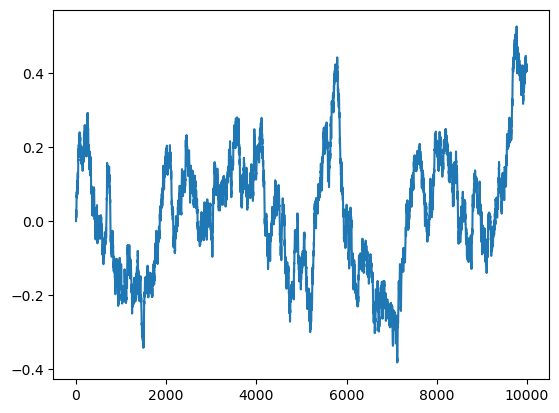

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1354574a8>

In [25]:
plot(xs)

The mean and s.d. are wildly wrong!

In [26]:
mean(xs), std(xs)

(0.023924329656756373, 0.16274526643983428)

Now too big steps:

In [27]:
xs = [0.0]
for i in 1:10000
    push!(xs, next_mcmc_state(xs[end], proposal_unit_normal_toobig, log_proposal_density_unit_normal, log_prob_unit_normal))
end

Here is a histogram of the samples we generated, which looks pretty unit-normal-y:

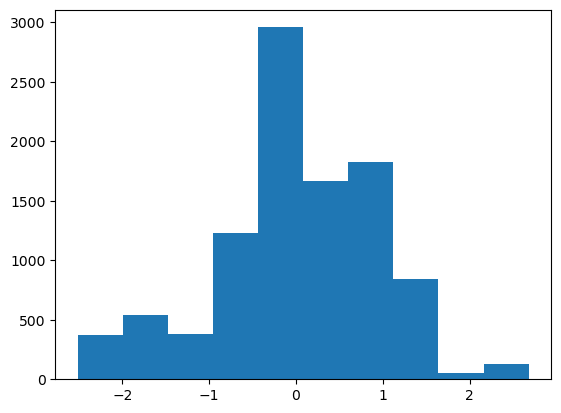

([374.0, 543.0, 378.0, 1232.0, 2959.0, 1665.0, 1826.0, 846.0, 53.0, 125.0], [-2.513585033884045, -1.9943555027192785, -1.4751259715545122, -0.9558964403897459, -0.4366669092249795, 0.08256262193978703, 0.6017921531045531, 1.1210216842693193, 1.6402512154340858, 2.1594807465988524, 2.678710277763618], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x135962668>, PyObject <matplotlib.patches.Rectangle object at 0x133244be0>, PyObject <matplotlib.patches.Rectangle object at 0x135962be0>, PyObject <matplotlib.patches.Rectangle object at 0x135962ef0>, PyObject <matplotlib.patches.Rectangle object at 0x135962f28>, PyObject <matplotlib.patches.Rectangle object at 0x135a16550>, PyObject <matplotlib.patches.Rectangle object at 0x135a16860>, PyObject <matplotlib.patches.Rectangle object at 0x135a16b70>, PyObject <matplotlib.patches.Rectangle object at 0x135a16e80>, PyObject <matplotlib.patches.Rectangle object at 0x135a16f98>])

In [28]:
hist(xs)

The exploration is a bit better, but you can still see long stretches of rejected jumps in the sampling.

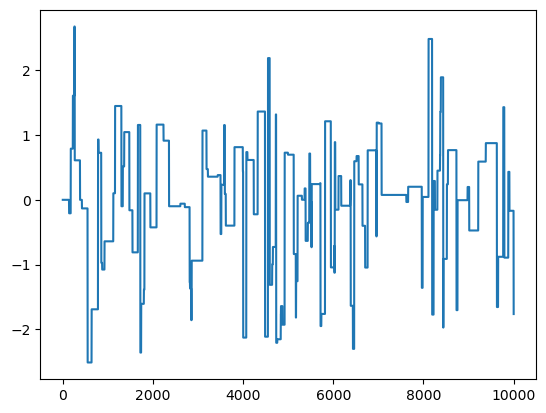

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x135ab1e80>

In [29]:
plot(xs)

The mean and s.d. are pretty inaccurate.

In [31]:
mean(xs), std(xs)

(0.003734305677914741, 0.9277393151377427)

Here is some code that measures the "autocorrelation length" of the sampling, to compute the "effective sample size" (smaller than the total number of samples because successive samples are correlated with each other).

In [32]:
function next_pow_two(n)
    i = 1
    while i < n
        i = i*2
    end
    return i
end

function autocorrelation_function(xs)
    xs = xs .- mean(xs)
    n = size(xs,1)
    N = next_pow_two(2*n)
    xs_ext = zeros(N)
    xs_ext[1:n] = xs
    ys = rfft(xs_ext)
    ys = ys.*conj(ys)
    acf = irfft(ys, N)
    acf = acf ./ acf[1]
    acf[1:n]
end

autocorrelation_function (generic function with 1 method)

In [33]:
acf = autocorrelation_function(xs)

10001-element Array{Float64,1}:
 1.0                  
 0.9827647431160956   
 0.9655294862321909   
 0.9482942293482866   
 0.931863816913934    
 0.9154276839938974   
 0.8989695862036763   
 0.8829118441174474   
 0.8670938922957427   
 0.8521021531912906   
 0.8372106660590051   
 0.8223713113371036   
 0.8077766250643985   
 ⋮                    
 2.978665052100089e-6 
 2.9035266982245276e-6
 2.8283883443786855e-6
 2.753249990522937e-6 
 2.678111636660584e-6 
 2.60297328281144e-6  
 2.5278349289457845e-6
 2.4526965750999425e-6
 2.3775582212309853e-6
 2.3024198673884454e-6
 1.5349465782534599e-6
 7.674732891118702e-7 

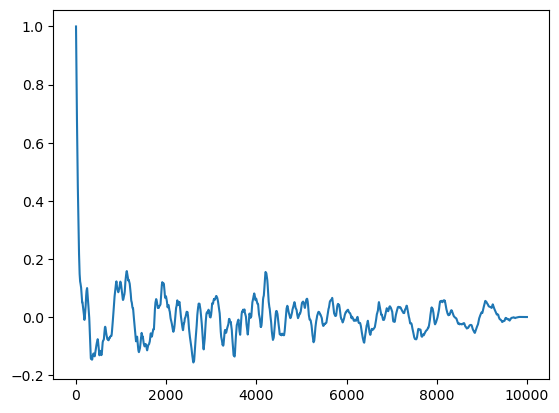

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x132d20b00>

In [34]:
plot(acf)

This is the autocorrelation length based on the above correlation function, choosing a reasonable interval to sum over:

In [36]:
sum(2 .* acf[1:500]) - 1

56.6789303739938

Here is some code that computes the partial sums, and stops as soon as it finds one that would imply that you have summed over at least five ACLs.  This is described more fully in [Sokal (1996)](https://pdfs.semanticscholar.org/0bfe/9e3db30605fe2d4d26e1a288a5e2997e7225.pdf)

In [37]:
function acl_estimate(xs)
    acf = autocorrelation_function(xs)
    
    sums = 0.0
    acl_est = 0.0
    for i in 1:size(xs, 1)
        sums = sums + acf[i]
        acl_est = 2.0*sums - 1.0
        if i > 5*acl_est && i > 1
            break
        end
    end
    
    if acl_est > 0.2*size(xs,1)
        return Inf
    else
        return acl_est
    end
end

acl_estimate (generic function with 1 method)

In [38]:
acl_estimate(xs)

78.95028629324896

Now we fit our actual problem, finding $V$, $R$, $\sigma$ given the observed currents

In [39]:
"""Returns a log-probability function given an array of observed currents."""
function make_log_prob(x, Iobs)
    Nobs = size(Iobs, 1)
    function lnprob(theta)
        V, R, sigma = theta
        
        if V < 0
            return -Inf
        end
        if R < 0
            return -Inf
        end
        if sigma < 0
            return -Inf
        end
        
        return -0.5*Nobs*log(2*pi)-Nobs*log(sigma) - 0.5*sum(((Iobs .- V./(R .+ x))/sigma).^2)
    end
end

make_log_prob

In [47]:
log_prob = make_log_prob(xs, ys)

(::getfield(Main, Symbol("#lnprob#5")){Array{Float64,1},Array{Float64,1},Int64}) (generic function with 1 method)

I manually tuned these proposal widths in class to get good sampling:

In [48]:
function circuit_fit_proposal(theta)
    V, R, sigma = theta
    
    return [V + 0.01*randn(), R+10*randn(), sigma+1e-5*randn()]
end

circuit_fit_proposal (generic function with 1 method)

In [49]:
function circuit_fit_log_prop_density(theta, theta_new)
    return 0.0
end

circuit_fit_log_prop_density (generic function with 1 method)

In [50]:
thetas = [[1.0, 1000.0, 1e-3]]
for i in 1:10000
    push!(thetas, next_mcmc_state(thetas[end], circuit_fit_proposal, circuit_fit_log_prop_density, log_prob))
end

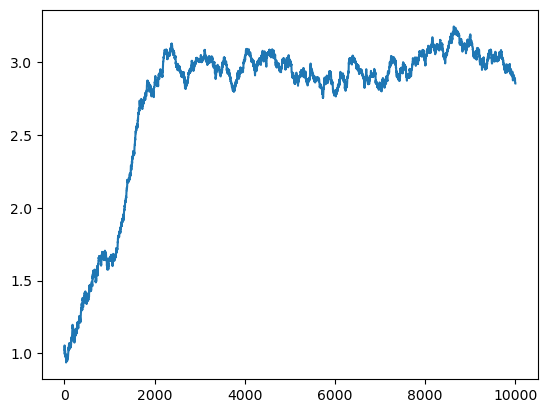

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1359b37b8>

In [51]:
plot([t[1] for t in thetas])

Since we see some burnin above, before the sampler settles down to a common state, let's do another run, starting from the end state above:

In [54]:
thetas = [thetas[end]]
for i in 1:10000
    push!(thetas, next_mcmc_state(thetas[end], circuit_fit_proposal, circuit_fit_log_prop_density, log_prob))
end

Now the traces look good:

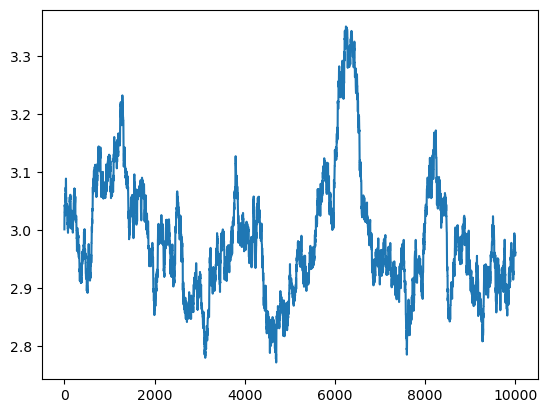

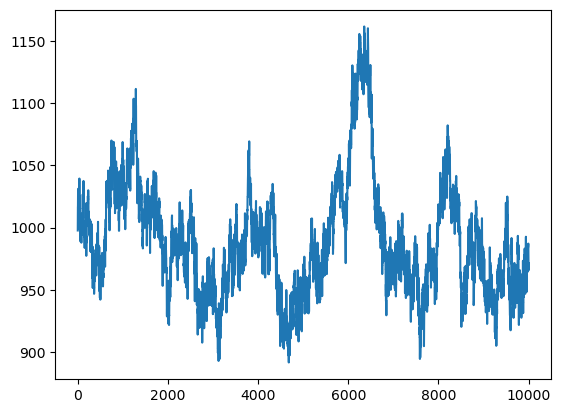

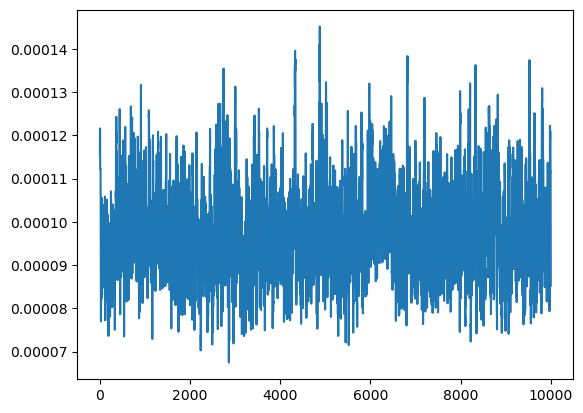

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1392d6ba8>

In [55]:
plot([t[1] for t in thetas])
figure()
plot([t[2] for t in thetas])
figure()
plot([t[3] for t in thetas])

Get our samples into a sensible format, a `(Nsamples, Nparameters)` matrix:

In [57]:
samples = hcat(thetas...)'

10001×3 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 3.00147   997.658  0.000115715
 3.03042  1016.55   0.000121595
 3.03042  1016.55   0.000121595
 3.03042  1016.55   0.000121595
 3.03042  1016.55   0.000121595
 3.04332  1026.94   0.000112473
 3.04122  1031.16   0.00011233 
 3.04122  1031.16   0.00011233 
 3.04122  1031.16   0.00011233 
 3.04122  1031.16   0.00011233 
 3.04122  1031.16   0.00011233 
 3.04122  1031.16   0.00011233 
 3.04122  1031.16   0.00011233 
 ⋮                             
 2.98109   985.279  0.000120617
 2.98109   985.279  0.000120617
 2.97677   987.124  0.000120421
 2.97677   987.124  0.000120421
 2.97755   982.501  0.000113339
 2.97306   978.507  0.000111585
 2.96376   978.98   0.000111658
 2.96376   978.98   0.000111658
 2.95627   972.546  0.000105093
 2.96282   965.7    9.72777e-5 
 2.96188   971.312  8.52441e-5 
 2.96188   971.312  8.52441e-5 

Let's make a corner plot, showing the 1- and 2-D distributions in our sampling.

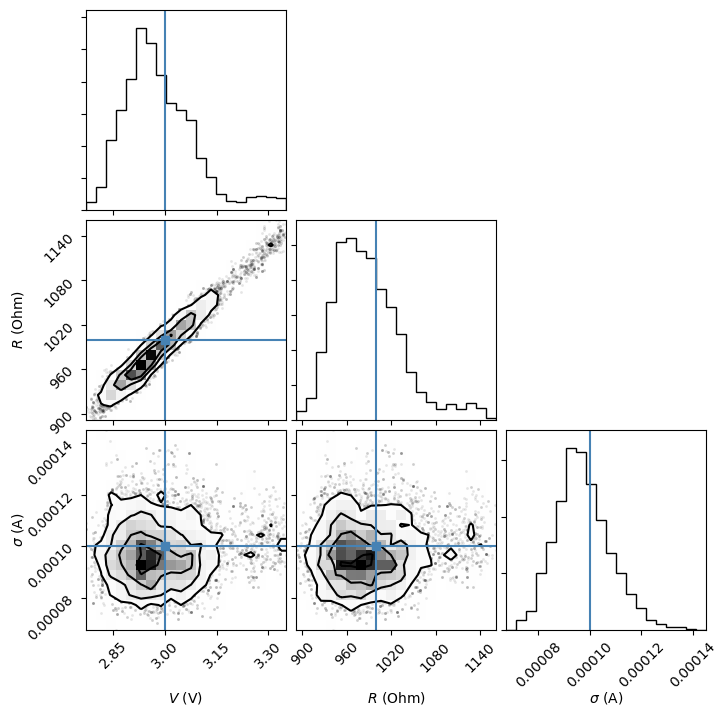

In [59]:
corner.corner(samples, 
    truths=[Vtrue, Rtrue, sigma_true], 
    labels=[L"$V$ ($\mathrm{V}$)",
            L"$R$ ($\mathrm{Ohm}$)",
            L"$\sigma$ ($\mathrm{A}$)"]);

And here we plot a few lines of the inferred $y$ vs $x$ relationship, by taking fair draws from our samples and plotting them against the data:

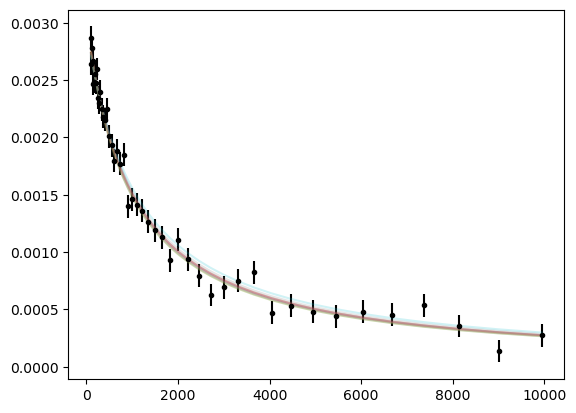

In [60]:
errorbar(xs, ys, yerr=sigma_true, fmt=".", color="k")
for i in 1:10
    j = rand(1:size(samples,1))
    V, R, sigma = samples[j,:]
    plot(xs, V./(R.+xs), alpha=0.2)
end

This is the inferred voltage, which matches the true voltage rather well (with uncertainty $\pm 0.1 \, \mathrm{V}$):

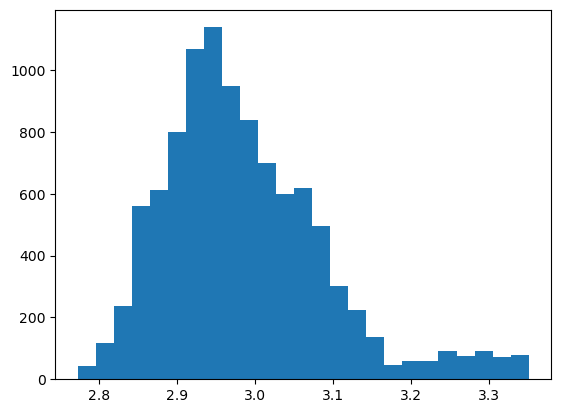

(2.9860739319846368, 0.10477035903122996)

In [61]:
hist(samples[:,1], bins=25)
mean(samples[:,1]), std(samples[:,1])